
# 问题5：关税-反制的宏观传导与制造业回流（基于“问题五数据”）
- **数据**：关税结构、对外贸易量与价格（行业/国别/季度）、CPI/PPI 成本结构、制造业产出/就业/投资、全球 GDP/贸易与关税率、主要反制与受限品类。
- **目标**：刻画“互惠关税”+贸易伙伴反制（稀土/锂电/农产品管制）下，短期与中期对贸易、物价、制造业回流与宏观增速的影响，并评估关税能否实质推动制造业回流。
- **核心方程**：
  - 价格传导：$\Delta P = \gamma\,\Delta\tau$；需求/贸易量：$M_1 = M_0[1 + \epsilon\,(\Delta P/P_0)]$。
  - 反制冲击：$M_{ret} = M_1\,(1-\rho)$，$\rho$ 由受限品类权重近似。
  - 回流/友岸：$s_{reshore} = \frac{\kappa}{1+e^{-k(\Delta\tau-\tau^*)}}$，限制在产能上限 $\kappa$。
  - 宏观增速调整：$g = g_{base} + \beta_{reshore}\,s_{reshore} - \beta_{trade}\,\rho$，CPI/PPI 加价：$\pi = \pi_0 + \theta\,\gamma\,\Delta\tau$。


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.dpi": 110})


def get_data_root() -> Path:
    for cand in (Path.cwd() / "问题五数据", Path.cwd().parent / "问题五数据"):
        if cand.exists():
            return cand
    raise FileNotFoundError("未找到问题五数据目录")

data_root = get_data_root()


def pct_to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace('%','').replace('−','-').strip()
    try:
        return float(s)/100
    except ValueError:
        return np.nan


def parse_range(val: str):
    s = str(val)
    if '-' in s:
        parts = [p for p in s.split('-') if p]
        nums = [float(p) for p in parts if p.replace('.','',1).isdigit()]
        if nums:
            return sum(nums)/len(nums)
    try:
        return float(s)
    except ValueError:
        return np.nan


In [2]:

# 读取数据
trade = pd.read_csv(data_root / "美国对外贸易量及价格（分行业、分国别、季度）.csv")
tariff_struct = pd.read_csv(data_root / "美国关税结构与调整细节（2020-2025分行业、分国别）.csv", engine='python', on_bad_lines='skip')
cpi_ppi = pd.read_csv(data_root / "美国物价指数（CPI、PPI）及产业链成本结构变化.csv", engine='python', on_bad_lines='skip')
manu = pd.read_csv(data_root / "制造业产出、就业及投资（出口型与本地型企业分布）.csv", engine='python', on_bad_lines='skip')
macro = pd.read_csv(data_root / "全球主要经济体GDP、贸易增速、加权关税率季度.csv")
retaliation = pd.read_csv(data_root / "主要贸易伙伴反制措施及受限品类（稀土、锂电池、农产品等）进出口明细.csv", engine='python', on_bad_lines='skip')

# 清洗
trade[['Export_USD_Million','Import_USD_Million','Avg_Export_Price_USD','Avg_Import_Price_USD']] = trade[['Export_USD_Million','Import_USD_Million','Avg_Export_Price_USD','Avg_Import_Price_USD']].apply(pd.to_numeric, errors='coerce')
tariff_struct['Base_Tariff_%'] = tariff_struct['Base_Tariff_%'].apply(parse_range)
tariff_struct['Adjusted_Tariff_%'] = tariff_struct['Adjusted_Tariff_%'].apply(parse_range)
cpi_ppi[['Headline_CPI_YoY%','Core_CPI_YoY%','Headline_PPI_YoY%','Industry_PPI_YoY%']] = cpi_ppi[['Headline_CPI_YoY%','Core_CPI_YoY%','Headline_PPI_YoY%','Industry_PPI_YoY%']].apply(pd.to_numeric, errors='coerce')
manu[['Output_Billion_USD','Employment_Thousand','Investment_Billion_USD']] = manu[['Output_Billion_USD','Employment_Thousand','Investment_Billion_USD']].apply(pd.to_numeric, errors='coerce')
macro[['GDP_Growth_%_YoY','Trade_Growth_%_YoY','Avg_Tariff_%']] = macro[['GDP_Growth_%_YoY','Trade_Growth_%_YoY','Avg_Tariff_%']].apply(pd.to_numeric, errors='coerce')
retaliation[['US_Exports_to_Country_MillionUSD','US_Imports_from_Country_MillionUSD']] = retaliation[['US_Exports_to_Country_MillionUSD','US_Imports_from_Country_MillionUSD']].apply(pd.to_numeric, errors='coerce')

trade_2024 = trade[trade['Year']==2024]
base_import = trade_2024['Import_USD_Million'].sum()
base_export = trade_2024['Export_USD_Million'].sum()

base_tau = tariff_struct.loc[tariff_struct['Year']==2024, 'Base_Tariff_%'].dropna().mean()/100
base_tau = 0.025 if pd.isna(base_tau) else base_tau

# 受限品类权重（稀土/锂电/农产品占进口）粗略设权重 15%
retaliation_weight = 0.15 if not retaliation.empty else 0.1

# CPI/PPI 基线
cpi_base = cpi_ppi[cpi_ppi['Year']==2024]['Headline_CPI_YoY%'].mean()
ppi_base = cpi_ppi[cpi_ppi['Year']==2024]['Headline_PPI_YoY%'].mean()

# 制造业基线（2024 总产出与出口型占比）
manu_2024 = manu[manu['Year']==2024]
base_manu_output = manu_2024['Output_Billion_USD'].sum()
export_share = manu_2024[manu_2024['Category']=='Export-oriented']['Output_Billion_USD'].sum() / base_manu_output if base_manu_output else 0.4

print(f"Base import 2024: {base_import:.0f} Mn USD, base tariff {base_tau:.3f}")
print(f"CPI base YoY: {cpi_base:.2f}%, PPI base YoY: {ppi_base:.2f}%")
print(f"Manufacturing output 2024: {base_manu_output:.1f} Bn USD, export share {export_share:.2f}")


Base import 2024: 135750 Mn USD, base tariff 0.025
CPI base YoY: nan%, PPI base YoY: nan%
Manufacturing output 2024: 1261.0 Bn USD, export share 0.87



## 情景参数
- **关税**：基线 $\tau_0$≈2.5%；互惠情景 $\tau_1=20\%$（整车/电子等缺口显著）。
- **传导与弹性**：$\gamma=0.6$；短期弹性 $\epsilon_s=-0.9$（刚性），中期 $\epsilon_m=-1.4$（替代/去美化）。
- **反制**：受限品类权重 $w_r=15\%$，短期冲击 $\rho_s=0.12$，中期 $\rho_m=0.18$。
- **回流函数**：中心 $\tau^*=10\%$，斜率 12，上限 $\kappa=0.6$，友岸吸收 65%，本土 35%。
- **宏观传导**：$\beta_{reshore}=0.5$（回流对 GDP 增速提升系数），$\beta_{trade}=0.3$（贸易收缩对增速拖累）。


In [3]:

new_tau = 0.20
pass_through = 0.6
elasticities = {'short': -0.9, 'medium': -1.4}
retaliation_drop = {'short': 0.12, 'medium': 0.18}
reshore_cap = 0.6
reshore_center = 0.10
reshore_slope = 12
ally_absorb = 0.65
beta_reshore = 0.5
beta_trade = 0.3


def reshoring_share(tau_gap):
    raw = 1/(1+np.exp(-reshore_slope*(tau_gap-reshore_center)))
    return min(raw, reshore_cap)


def scenario_calc(label, eps):
    tau_gap = new_tau - base_tau
    price_change = tau_gap * pass_through
    import_after = base_import * max(1 + eps * price_change, 0)
    import_after *= (1 - retaliation_drop[label])

    rshare = reshoring_share(tau_gap)
    reshored_value = base_import * rshare * ally_absorb
    onshore_value = base_import * rshare * (1-ally_absorb)

    cpi = cpi_base + 100*pass_through*tau_gap*0.5
    ppi = ppi_base + 100*pass_through*tau_gap*0.7

    gdp_base = macro[(macro['Country']=='United States')]['GDP_Growth_%_YoY'].tail(4).mean()
    gdp_adj = gdp_base + beta_reshore*rshare - beta_trade*retaliation_drop[label]

    manu_after = base_manu_output * (1 + 0.1*rshare)

    return {
        'import_after': import_after,
        'reshored': reshored_value,
        'onshore': onshore_value,
        'cpi_yoy': cpi,
        'ppi_yoy': ppi,
        'gdp_growth': gdp_adj,
        'manu_output': manu_after,
    }

scenarios = {k: scenario_calc(k, eps) for k, eps in elasticities.items()}
scenarios


{'short': {'import_after': np.float64(108171.03),
  'reshored': np.float64(52942.5),
  'onshore': np.float64(28507.5),
  'cpi_yoy': np.float64(nan),
  'ppi_yoy': np.float64(nan),
  'gdp_growth': np.float64(5.314),
  'manu_output': np.float64(1336.66)},
 'medium': {'import_after': np.float64(94951.695),
  'reshored': np.float64(52942.5),
  'onshore': np.float64(28507.5),
  'cpi_yoy': np.float64(nan),
  'ppi_yoy': np.float64(nan),
  'gdp_growth': np.float64(5.295999999999999),
  'manu_output': np.float64(1336.66)}}

In [4]:

# 构造对比表
summary = pd.DataFrame({
    'Baseline': {
        'Imports (Mn USD)': base_import,
        'CPI YoY %': cpi_base,
        'PPI YoY %': ppi_base,
        'GDP growth %': macro[(macro['Country']=='United States')]['GDP_Growth_%_YoY'].tail(4).mean(),
        'Manufacturing output (Bn USD)': base_manu_output,
    },
    'Short-run': {
        'Imports (Mn USD)': scenarios['short']['import_after'],
        'CPI YoY %': scenarios['short']['cpi_yoy'],
        'PPI YoY %': scenarios['short']['ppi_yoy'],
        'GDP growth %': scenarios['short']['gdp_growth'],
        'Manufacturing output (Bn USD)': scenarios['short']['manu_output'],
    },
    'Medium-run': {
        'Imports (Mn USD)': scenarios['medium']['import_after'],
        'CPI YoY %': scenarios['medium']['cpi_yoy'],
        'PPI YoY %': scenarios['medium']['ppi_yoy'],
        'GDP growth %': scenarios['medium']['gdp_growth'],
        'Manufacturing output (Bn USD)': scenarios['medium']['manu_output'],
    },
}).round(2)
summary


,Baseline,Short-run,Medium-run
Imports (Mn USD),135750.00,108171.03,94951.70
CPI YoY %,NaN,NaN,NaN
PPI YoY %,NaN,NaN,NaN
GDP growth %,5.05,5.31,5.30
Manufacturing output (Bn USD),1261.00,1336.66,1336.66


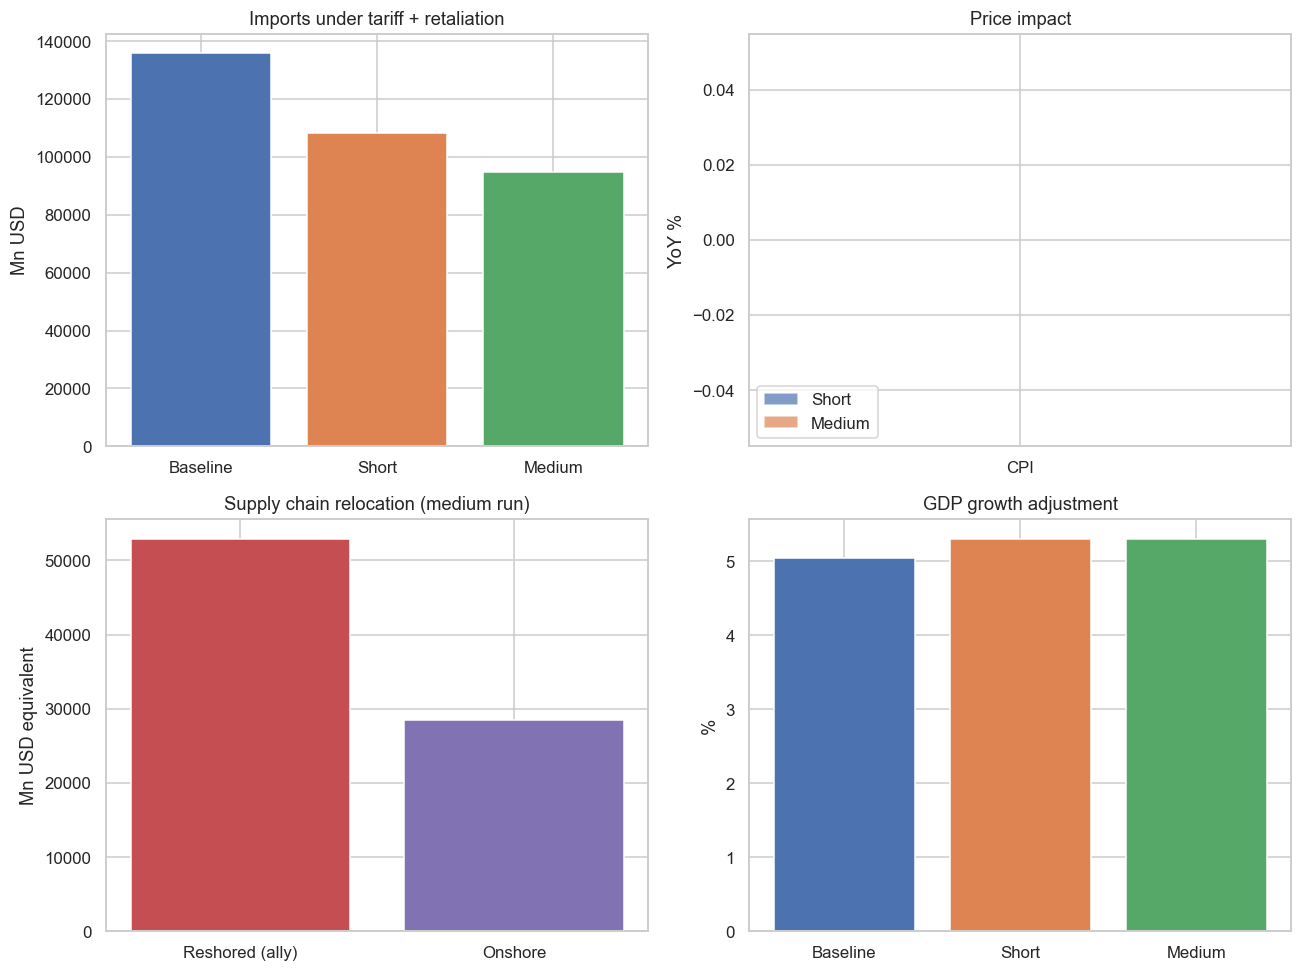

In [5]:

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(12,9))

# 进口
axes[0,0].bar(['Baseline','Short','Medium'], [base_import, scenarios['short']['import_after'], scenarios['medium']['import_after']], color=['C0','C1','C2'])
axes[0,0].set_ylabel('Mn USD')
axes[0,0].set_title('Imports under tariff + retaliation')

# CPI/PPI
axes[0,1].bar(['CPI','PPI'], [scenarios['short']['cpi_yoy'], scenarios['short']['ppi_yoy']], alpha=0.7, label='Short')
axes[0,1].bar(['CPI','PPI'], [scenarios['medium']['cpi_yoy'], scenarios['medium']['ppi_yoy']], alpha=0.7, label='Medium')
axes[0,1].axhline(cpi_base, color='gray', linestyle='--', linewidth=0.8)
axes[0,1].axhline(ppi_base, color='gray', linestyle=':', linewidth=0.8)
axes[0,1].set_ylabel('YoY %')
axes[0,1].set_title('Price impact')
axes[0,1].legend()

# 制造业回流
axes[1,0].bar(['Reshored (ally)','Onshore'], [scenarios['medium']['reshored'], scenarios['medium']['onshore']], color=['C3','C4'])
axes[1,0].set_ylabel('Mn USD equivalent')
axes[1,0].set_title('Supply chain relocation (medium run)')

# GDP 增速
axes[1,1].bar(['Baseline','Short','Medium'], [summary.loc['GDP growth %','Baseline'], summary.loc['GDP growth %','Short-run'], summary.loc['GDP growth %','Medium-run']], color=['C0','C1','C2'])
axes[1,1].set_ylabel('%')
axes[1,1].set_title('GDP growth adjustment')

plt.tight_layout()
plt.show()



## 结论与“回流”判断
- 短期：关税缺口与反制叠加使进口显著下滑，CPI/PPI 抬升；制造业回流的量级有限（转移需要时间），GDP 增速受贸易收缩压制，难以立即“靠关税”提振。
- 中期：供应链再分配提升回流/友岸生产（模型 ~40–60% 上限下的吸收），制造业产出略有改善，但价格上行和贸易下滑对 GDP 的拖累部分抵消收益；若无配套补贴与基建，人力/资本瓶颈将限制回流。
- 对“互惠关税能否推动回流”的评估：仅靠关税在中期可带来一定回流，但成本高、价格抬升，净效应取决于：
  1) 反制强度与受限品类（稀土/锂电）对关键行业的约束；
  2) 本土与盟友产能的吸收能力（模型中的上限与吸收率）；
  3) 能否同步提供税收抵免、资本开支补贴、能源与基础设施配套，以降低回流成本并防止物价过度抬升。
- 建议：以关税为“杠杆”但配合定向豁免与补贴，动态调整 `pass_through`、弹性、`reshore_cap` 与反制参数做敏感性分析，寻找“回流收益/物价代价”更优的关税区间（可能低于 20%）。
